In [1]:
#!pip install --upgrade pip
#!pip install scikit-learn --upgrade
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib
#!pip install imblearn
#!pip install --upgrade joblib
from time import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

## Στοιχεία Ομάδας

Ομάδα: A18

Καλογεράς Ανδρέας (03114822)

Λούρας Χρήστος (03114037)

## Εισαγωγή του Dataset

1. Το Dataset που θα χρησιμοποιήσουμε, αφορά την πρόγνωση χρεοκοπίας επιχειρήσεων στην πολωνία. Συγκεκριμένα, η περίοδος πρόγνωσης είναι 5 χρόνια και βάσει αυτού του χαρακτηριστικού χωρίζονται σε κλάσεις. Έχουμε λοιπόν 5 κλάσεις(1ο, 2ο,3ο,4ο,5ο έτος), όπου η κάθε κλάση περιέχει τα οικονομικά δεδομένα του εκάστοτε έτους πρόγνωσης και η ετικέτα της κάθε κλάσης έιναι "Χρεοκοπία μετα από (5,4,3,2,1) έτη". Κάθε κλάση διακρίνει 2 καταστάσεις των εταιριών, με βάση το αν η εταιρία χρεοκόπησε στο έτος πρόγνωσης η όχι. Έτσι, έχουμε τις καταστάσεις "Χρεοκοπία στο έτος πρόγνωσης" και "Όχι χρεοκοπία στο έτος πρόγνωσης". Αυτές είναι και οι καταστάσεις στις οποίες θα εκπαιδεύσουμε τους classifiers μας.

2. Το εν λόγω Dataset περιέχει 10503 δείγματα τα οποία περιγράφονται απο 64 χαρακτηριστικά.

3. Δέν υπάρχουν επικεφαλίδες στο dataset μας, ούτε αρίθμηση των δειγμάτων.

4. Οι ετικέτες για την κάθε κλάση μας βρίσκονται στην 58η στήλη. Η 58η στήλη είναι ο λόγος των συνολικών εξόδων προς τα συνολικά έσοδα. Επομένως, εάν μία εταιρεία έχει τιμή μεγαλύτερη από 1 σε αυτή την στήλη, θα έχει χρεοκοπήσει. Επειδή για την εκπαίδευση των classifiers μας θα χρειαστούμε 2 τιμές για τις κλάσεις, αργότερα θα μετατρέψουμε τις τιμές αυτής της στήλης σε 0(μή χρεοκοπία) και 1(χρεοκοπία).

5. Τα δεδομένα μας ήταν σε αρχεία .arff, επομένως για να τα χρησιμοποιήσουμε τα μετατρέψαμε σε .csv χρησιμοποιώντας(αντίστοιχα και για τα άλλα 4) την εξής εντολή στο cmd(στο directory που βρίσκονται τα αρχεία μας):

In [ ]:
# Windows
#!findstr/BV "@" 5year.arff | findstr /BV "%" | findstr /V /R /C:"^[]*$"> 5year.csv

In [ ]:
# Linux
#!cat 5year.arff | grep -ve "^@\|^%" | grep -v "^[[:space:]]*$" > 5year.csv

6. Υπάρχουν απουσιάζουσες τιμές. Επιπλέον, υπάρχουν τιμές οι οποίες είναι εκτός του αναμενόμενου εύρους(λανθασμένες).

In [2]:
df1 = pd.read_csv("1year.csv", header=None)
df2 = pd.read_csv("2year.csv", header=None)
df3 = pd.read_csv("3year.csv", header=None)
df4 = pd.read_csv("4year.csv", header=None)
df5 = pd.read_csv("5year.csv", header=None)

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [ ]:
# concat all csv files to one
!cat *year.csv > big.csv #Linux
#copy *year.csv big.csv

In [3]:
df = pd.read_csv("big.csv", header = None, na_values=["?"])
print(df.shape)
#print(df)

(43405, 65)


Αποθηκεύουμε τα χαρακτηρηστικά στον πίνακα featues και τις ετικέτες(65η στήλη) στον πίνακα labels. Κάνοντας print το df, θα διαπιστώσουμε ότι στη γραμμή 43405 δεν υπάρχουν καθόλου τιμές, επομένως την αφαιρούμε εξαρχής:

In [4]:
#df = df.drop(df.index[43405]) #remove last row
features = df.iloc[:, :64]
print(features)

labels = np.array(df.iloc[:, 64])
labels = labels.astype(int) #convert to integer values
print (labels)

             0         1         2         3             4         5   \
0      0.200550  0.379510  0.396410   2.04720  3.235100e+01  0.388250   
1      0.209120  0.499880  0.472250   1.94470  1.478600e+01  0.000000   
2      0.248660  0.695920  0.267130   1.55480 -1.152300e+00  0.000000   
3      0.081483  0.307340  0.458790   2.49280  5.195200e+01  0.149880   
4      0.187320  0.613230  0.229600   1.40630 -7.312800e+00  0.187320   
5      0.228220  0.497940  0.359690   1.75020 -4.771700e+01  0.000000   
6      0.111090  0.647440  0.289710   1.47050  2.534900e+00  0.000000   
7      0.532320  0.027059  0.705540  53.95400  2.995800e+02  0.000000   
8      0.009020  0.632020  0.053735   1.12630 -3.784200e+01  0.000000   
9      0.124080  0.838370  0.142040   1.16940 -9.188300e+01  0.000000   
10     0.240010  0.443550  0.188350   1.44000 -2.116500e+01 -0.931900   
11    -0.027117  0.111480  0.119890   2.07540 -3.164300e+01 -0.084883   
12     0.266690  0.349940  0.611470   3.02430  4.30

7. Έχουμε 2 κλάσεις, την 0 και την 1.

In [5]:
labels_size = labels.shape
counts = np.bincount(labels)
freqs = counts / labels_size
print("Frequency of 0 =",freqs[0]*100,"%")
print("Frequency of 1 =",freqs[1]*100,"%")

Frequency of 0 = 95.18258265176823 %
Frequency of 1 = 4.81741734823177 %


Το 0 (μη χρεοκοπημένη επιχείρηση) έχει συχνότητα 95% ενώ το 1 (χρεοκοπία) έχει συχνότητα 5%. Επομένως το dataset παρουσιάζει τεράστια ανισορροπία. 

8. Στη συνέχεια χωρίζουμε το dataset σε Train και Train Test:

In [6]:
train, test, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)
print(train.shape)
print(test.shape)

(30383, 64)
(13022, 64)


Υπάρχουν missing values, οπότε ελέγχουμε σε πόσες γραμμές υπάρχουν:

In [7]:
#linux
!cat big.csv | grep "?" |  wc -l
#windows
#!findstr "?" data.csv |  find /c /v ""


23438


Επειδή το πλήθος των δειγμάτων με απουσιάζουσες τιμές είναι αρκετά μεγάλο (>50%), θα χρησιμοποιήσουμε τον μετασχηματιστή SimpleImputer, με τον οποίο οι απουσιάζουσες τιμές αντικαθίστονται με την μέση τιμή της στήλης στην οποία βρίσκονται, το οποίο είναι δυνατό αφού έχουμε μόνο features με αριθμητικές τιμές. Πρίν γίνει αυτό όμως, χωρίζουμε το dataset σε train και test set.

Επίσης, κάνουμε fit μόνο στο train και βάσει αυτού μετασχηματίζουμε τα train και test sets.

In [8]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(train)
train = pd.DataFrame(imp_mean.transform(train))
test = pd.DataFrame(imp_mean.transform(test))

## Baseline classification

1. Πρώτα εκπαιδεύουμε όλους τους ταξινομητές με default υπερπαραμέτρους και το dataset δίχως κάποια προ-επεξεργασία πέρα απο το ζήτημα των απουσιάζουσων τιμών. Για το περιορισμό επαναλαμβανόμενου κώδικα υλοποιούμε μία for-loop που κάνει fit,predict, αποθήκευση f1 scores, και εκτύπωση αποτελεσμάτων για κάθε ένα απο τους εξείς ταξινομητές:
    1. Dummy Classifiers (Uniform, Contant 0 ,Constant 1, Most Frequent, Stratified)
    2. Gaussian Naive Bayes (GNB)
    3. K Nearest Neighbors (kNN)
    3. Multi-Layer Percepton (MLP)

Αρχικοποιούμε τους ταξινομητές σε μία λίστα για την for-loop:

In [9]:
# Dictionary for the results of the Classifiers
baseline_f1_micro = {}
baseline_f1_macro = {}

# Initialize all classifiers with default values
classifiers = [
            ('Uniform', DummyClassifier(strategy='uniform')),
            ('Constant 0', DummyClassifier(strategy='constant', constant=0)),
            ('Constant 1', DummyClassifier(strategy='constant', constant=1)),
            ('Most Frequent', DummyClassifier(strategy='most_frequent')),
            ('Stratified', DummyClassifier(strategy='stratified')),
            ('GNB', GaussianNB()),
            ('kNN', KNeighborsClassifier()),
            ('MLP', MLPClassifier())]


Τρέχουμε το for-loop:

In [10]:
for (name, cl) in classifiers:
    print(name, "\n")
    model = cl.fit(train, train_labels)
    pred = cl.predict(test)
    # save f1 micro and f1 macro
    baseline_f1_micro[name] = f1_score(test_labels, pred, average="micro")
    baseline_f1_macro[name] = f1_score(test_labels, pred, average="macro")
    # print results:
    print("Confusion matrix:\n" ,confusion_matrix(test_labels, pred), "\n")
    print("F1_micro score:" ,baseline_f1_micro[name])
    print("F1 macro score:" ,baseline_f1_macro[name], "\n")
    print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Uniform 

Confusion matrix:
 [[6256 6175]
 [ 279  312]] 

F1_micro score: 0.5043772078021809
F1 macro score: 0.37393367057070975 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.96      0.50      0.66     12431
           1       0.05      0.53      0.09       591

   micro avg       0.50      0.50      0.50     13022
   macro avg       0.50      0.52      0.37     13022
weighted avg       0.92      0.50      0.63     13022

Constant 0 

Confusion matrix:
 [[12431     0]
 [  591     0]] 

F1_micro score: 0.9546152664721241
F1 macro score: 0.4883903665579696 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     12431
           1       0.00      0.00      0.00       591

   micro avg       0.95      0.95      0.95     13022
   macro avg       0.48      0.50      0.49     13022
weighted avg       0.91      0.95      0.93     13022

Constant 1 

Confu

2. Bar plots για τα f1-micro και f1-macro:

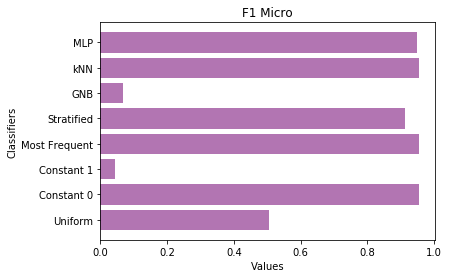

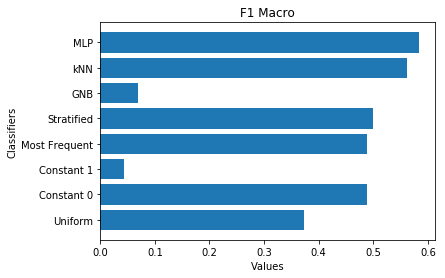

In [11]:
##Firstly for F1 Micro
# Split dictionary
names = list(baseline_f1_micro.keys())
values = list(baseline_f1_micro.values())
y_pos = np.arange(len(names))
# Create horizontal bars and color
plt.barh(y_pos, values, color = (0.5,0.1,0.5,0.6))
# Add names to axis
plt.title('F1 Micro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
# Create names
plt.yticks(y_pos, names)
# Show graphic
plt.show()

##Firstly for F1 Macro
# Split dictionary
names = list(baseline_f1_macro.keys())
values = list(baseline_f1_macro.values())
y_pos = np.arange(len(names))
# Create horizontal bars and color
plt.barh(y_pos, values)
# Add names to axis
plt.title('F1 Macro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
# Create names
plt.yticks(y_pos, names)
# Show graphic
plt.show()


3. Σχολιασμός αποτελεσμάτων:

Συγκρίνουμε τα confusion matrices για κάθε μέθοδο ταξινόμησης. Αρχικά βλέπουμε πως στην constant 0 και στην most frequent ταυτίζονται τα confusion matrices, διότι η κλάση που υπερισχύει πανηγυρικά στο dataset μας είναι η 0. Για την constant 1 το confusion matrix είναι το "συμπληρωματικό ως προς τις στήλες" των constant 0 και most frequent. Στις μεθόδους kNN και stratified οι confusion matrices έχουν παρόμοια μορφή και κατανομή, ενώ βλέπουμε ότι η μέθοδος GNB έχει τις λιγότερες επιτυχημένες προσπάθειες από όλους(με εξαίρεση φυσικά της μεθόδου constant 1 όπου η κλάση 1 έχει συχνότητα της τάξης του 5%). Τα περισσότερα True Positives τα έχει ο confusion matrix του kNN, ενώ εξίσου αποδοτική είναι και η MLP, σύμφωνα με το confusion matrix της. Επίσης, συνολικά το MLP έχει τα καλύτερα αποτελέσματα στο baseline.

Πηγαίνοντας τώρα στα plot, στο f1 micro έχουμε γενικά υψηλά scores. Οι αλγόριθμοι MLP και kNN, λόγω της άνισης κατανομής του dataset, προβλέπουν ευκολότερα την πιο συχνή κλάση. (Για τον kNN έχει εξηγηθεί ο λόγος στο small notebook). Λόγω του αρχικού training set ,που έχει πολύ άνιση κατανομή, τα bias-weights του νευρωνικού δικτύου το MLP είναι πιο "προαρμοσμένα" στο να ανιχνεύουν την κυρίαρχη κλάση. Επίσης, λόγω της συχνοτικής υπεροχής της κλάσης 0, επίσης πολύ υψηλο σκόρ έχουν οι τεχνικές Most Frequent, Stratified και Constant 0, σε αντίθεση με την Constant 1, για τον ίδιο λόγο. Η τεχνική uniform όπως αναμέναμε θα παρουσίαζε μία μέση απόδοση, διότι ο dummy classifier σε αυτή τη τεχνική επιλέγει τυχαία και ομοιόμορφα. Τέλος, βλέπουμε αποτυχία στον ταξινομητή GNB, ο λόγος περιγράφει πιο κάτω αναλυτικά.

Στο f1 macro πέφτει σημαντικά το σκόρ σε όλους τους classifiers που "χτυπήσαν" υψηλό σκορ στο micro. Όπως εξηγήσαμε και στο small notebook, η f1 micro επηρεάζεται σημαντικά από άνισα κατανεμημένα δείγματα (λόγω του τρόπου με τον οποίο έχει ορισθεί μαθηματικά), επομένως όλοι οι αλγόριθμοι που προβλέπουν ευκολότερα την πιο συχνή κλάση, δε θα έχουν παρόμοιο καλό σκόρ στην f1 macro. Παρόλα αυτά και πάλι επικρατούν έναντι των υπολοίπων classifiers (εκτός του GNB). Παρατηρούμε πως οι GNB και Constant 1 δεν έχουν κάποια αξιόλογη μεταβολή(αναμενόμενο, καθώς ο Constant 1 προβλέπει πάντοτε την κλάση 1 που εδώ έχει πολύ χαμηλή συχνότητα). Υπενθυμίζουμε πως η f1 macro λαμβάνει τον συνολικό μέσο όρο στα metrics, χωρίς η ποσότητα των δειγμάτων να επηρεάζει το αποτέλεσμα.  

Η αποτυχία του GNB βάσει των f1 scores οφείλεται στον τρόπο με τον οποίο λειτουργεί αυτός ο ταξινομητής. Πιο συγκεκριμένα, ο εν λόγω ταξινομητής βγάζει ώς έξοδο(πρόβλεψη) το γινόμενο της σχετικής συχνότητας της εκάστοτε κλάσης στο training set και της πιθανότητας του δείγματος με δεδομένη την υπόθεση μας(ότι η κλάση είναι 0 η 1). Επειδή λοιπόν η πιθανότητα P(0) (σχετική συχνότητα της κλάσης 0) είναι συντριπτικά μεγαλύτερη από την P(1), το P(Xi|1) (Όπου xi το δείγμα) θα είναι εξαιρετικά μικρό, και θα δίνει συνήθως λανθασμένη πρόβλεψη.

Τελικά, με default τιμές και χωρίς προ-επεξεργασία, η καλύτερη μας επιλογή για το πρόβλημα μας είναι το MLP που έχει τις καλύτερες τιμές overally. Επίσης , ο GNB έχει το μεγαλύτερο εν δυνάμει περιθώριο βελτιστοποίησης που στο baseline παρουσιάζει τραγικά αποτελέσματα.

## Βελτιστοποίηση ταξινομητών

Στην ενότητα αυτή θα προσπαθήσουμε να βελτιώσουμε τος ταξινομήτες χρησιμοποιώντας μερασχηματιστές πριν την τελική ταξινόμηση και επίλεγοντας τις βέλτιστες υπερπαραμέτρους που παίζουν το σημαντικότερο ρόλο. Για την αυτοματοποίηση της έυρεσης των κατάλληλων τιμών θα χρησιμοποιήσουμε Pipelines και GridSearchCV ώστε να βρούμε τις καλύτερες αρχιτεκτονικές. Επιπλέον, θα δημιουργήσουμε ένα τυχαίο μικρότερο dataset από το train set με το οποίο θα γίνει το πρώτο στάδιο του cross-validation (μέσω του GridSearchCV) και στην συνέχεια θα επεκταθούμε στην χρήση ολόκληρου του train set για να σιγουρέψουμε τις επιλογές μας.

Δημουργία του μικρότερου dataset:

In [21]:
sdata, starget = shuffle(train, train_labels, random_state = 1000)
samples = 10000
data = sdata.iloc[0:samples-1,:]
target = starget[0:samples-1]

Συχνότητα ετικετών στα λιγότερα δείγματα:

In [22]:
target_size = target.shape
counts = np.bincount(target)
freqs = counts / target_size
print("Frequency of 0 =",freqs[0]*100,"%")
print("Frequency of 1 =",freqs[1]*100,"%")

Frequency of 0 = 95.1895189518952 %
Frequency of 1 = 4.81048104810481 %


#### Gaussian Naive Bayes:

Στον GNB δεν έχουμε κάποια σημαντική υπερπαράμετρο, οπότε θα περιοριστούμε στην βελτιστοποίηση της προ-επεξεργασίας.

Αρχικοποιούμε τους διάφορους ταξινομητές-μετασχηματιστές και ορίζουμε τα βήματα του pipeline, το pipeline και τις διάφορες περιπτώσεις που θα εξετάσει ο GridSearchCV για το Gaussian Naive Bayes. Συγκεκριμένα, θα εξετάσουμε 1 Scaler ή κανέναν, έναν Sampler ή κανέναν και διάφορες τιμές για το PCA. Για μετρική το f1 micro:
1. Aρχικά για το PCA δώθηκαν οι τιμές : [2, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 64] και γύρισε ως καλύτερη τιμή το 2.
2. Στην συνέχεια ελέγχουμε πιο κοντά: [2, 3, 4, 5] και γυρίζει πάλι ως καλύτερη τιμή το 2 ξανά.  
Οπότε, συνολικά χαρακτηριστικά για το καλύτερο pipeline με μετρική το f1 micro:
VarianceThreshold() -> StandardScaler() ->RandomOverSampler() -> PCA(2) -> GNB()

Παρακάτω ο κώδικας που δίνει το τελικό αποτέλεσμα με cross-validation σε όλο το train set και μετρική με f1 micro.

In [12]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
gnb = GaussianNB()

# Steps of the pipeline
steps = [('selector', selector),
         ('scaler', scaler),
         ('sampler', ros),
         ('pca', pca),
         ('GNB', gnb)
        ]
memory = 'tmp'

# dictionary of values for the parameters
val_dict = dict(
                scaler=[StandardScaler(), None],
                sampler=[RandomOverSampler(), None], 
                pca__n_components=[2, 3, 4, 5]
               )


# Initalizing Pipeline
pipe = Pipeline(steps, memory)
# GridSearchCV
estimator = GridSearchCV(pipe, val_dict, n_jobs=-1, cv=5, scoring='f1_micro')
estimator.fit(train, train_labels)
print(estimator.best_estimator_)   
print(estimator.best_params_)
print()

Pipeline(memory='tmp',
     steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('GNB', GaussianNB(priors=None, var_smoothing=1e-09))])
{'pca__n_components': 2, 'sampler': RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto'), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Όμοίως για f1 macro:  
Πρώτα θα βρούμε τις καλύτερες τιμές σε ολόκληρο το dataset που δημιουργήσαμε νωρίτερα.  
Τα βήματα του pipeline είναι ίδια.
Συγκεκριμένα, θα εξετάσουμε 1 Scaler ή κανέναν, έναν Sampler ή κανέναν και διάφορες τιμές για το PCA.
1. Aρχικά για το PCA δώθηκαν οι τιμές στον πρώτο γύρο είναι [2, 10, 20, 30, 40, 50, 60, 64] και γύρισε ως καλύτερη τιμή το 2.  
2. Στην συνέχεια ελέγχουμε πιο κοντά: [1, 2, 3, 4, 5] και σε όλο το train set. Δίνει ως βέλτιστη τιμή το 2 για το PCA.  
Συνολικά χαρακτηριστικά για το καλύτερο pipeline με μετρική το f1 macro:
VarianceThreshold() -> StandardScaler() ->RandonOverSampler() -> PCA(2) -> GNB()

Παρακάτω ο κώδικας που δίνει το τελικό αποτέλεσμα με cross-validation σε όλο το train set και μετρική το f1 macro.

In [33]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
gnb = GaussianNB()

# Steps of the pipeline
steps = [('selector', selector),
         ('scaler', scaler),
         ('sampler', ros),
         ('pca', pca),
         ('GNB', gnb)
        ]
memory = 'tmp'

# dictionary of v
# alues for the parameters
val_dict = dict(
                scaler=[StandardScaler(), None],
                sampler=[RandomOverSampler(), None], 
                pca__n_components=[1, 2, 3, 4, 5]
               )


# Initalizing Pipeline
pipe = Pipeline(steps, memory)
# GridSearchCV
estimator = GridSearchCV(pipe, val_dict, n_jobs=-1, cv=5, scoring='f1_macro')
estimator.fit(train, train_labels)
print(estimator.best_estimator_)   
print(estimator.best_params_)
print()

Pipeline(memory='tmp',
     steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('GNB', GaussianNB(priors=None, var_smoothing=1e-09))])
{'pca__n_components': 2, 'sampler': RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto'), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Παρατηρούμε ότι στην προκειμένη περίπτωση (διατηρούμε επιφύλαξη λόγωτου random split του dataset) βγήκε ίδιο βέλτιστο pipeline και για τις 2 μετρικές. Οπότε, δεν χρειάζεται να γίνουν ξεχωριστά διαγράμματα για gnb micro και macro.

#### K Nearest Neighbors:

Για το ΚΝΝ θα ασχοληθούμε με την εύρεση βέλτιστων τιμών για 3 υπερπαραμέτρους του:  
1. n_neighbors : ο αριθμός των γειτόνων που λαμβάνονται υπόψιν για την ταξινόμηση ενός στοιχείου. Ασχοληθήκαμε με αυτήν την υπερπαράμετρο και στο small notebook.
2. weights : παίρνε 3 δυνατές τιμές : 'uniform', 'distance' ή μία οριζόμενη συνάρτηση απο τον χρήστη και επηρρεάζει το 'βάρος' κοντινού κόμβου στην αποτίμηση του τελικού αποτελέσματος. Εμείς θα ασχοληθούμε με τις πρώτες 2 περιπτώσει, όπου 'uniform' σημαίνει ίσο βάρος για κάθε σημείο και 'distance' σημαίνει ότι το βάρος επηρρεάζεται από την απόσταση που έχει ένα σημείο σε σχέση με αυτό που μελετάται (όσο πιο κοντά, τόσο το καλύτερο).
3. metric : καθορίζει τον τρόπο υπολογισμού της απόστασης μεταξύ 2 σημείων του χώρου. Οι περιπτώσεις που θα μελετήσουμε λόγω του τύπου στοιχείων που έχουμε στο dataset είναι : 'euclidean', 'manhattan', 'chebyshev', 'minkowski'

Στο pipeline έχουμε 2 scalers ή κανεναν, έναν sampler ή κανέναν, PCA και στο τέλος τον ταξινομητή kNN.

Δεν υπάρχει λόγος να ασχοληθούμε σημαντικά ώστε να βελτιώσουμε το f1 micro. Καλύτερο είναι να επικεντρωθούμε στο f1 macro ώστε αν γίνεται να το αυξήσουμε ακόμα και με κάποιο trade-off στο f1 micro ώστε να έχουμε ομοιόμορφη συμπεριφορά πρόβλεψης ανάμεσα στις κλάσεις.  
Στο baseline η τιμή του είναι >=0.95 που οφείελεται στην μεγάλη διαφορά του πλήθους κάθε κλάσης. Το dataset με το οποίο εξετάζουμε στις αρχικές αναζητήσεις είναι αρκετά μικρό και παρουσιάζει περίπου την ίδια συχνότητα των κλάσεων που έχει και το αρχικό.

Στην συνέχεια, τρέχουμε τον παρακάτω κώδικα GridSearchCV με train set μεγέθους <= 1000 με τιμές για PCA : [10, 20, 30, 40, 50, 60, 64] και για kNN για γείτονες : [5, 10, 20, 30, 40, 50], για μετρικές: ['euclidean', 'manhattan', 'chebyshev', 'minkowski'] και για weight: ['uniform', 'distance'] και πέρνουμε ως βέλτιστη αρχιτετονική:

knn__metric: euclidean  
knn__n_neighbors : 10   
knn__weights : uniform   
pca__n_components : 30  
sampler : None  
scaler : StandardScaler(copy=True, with_mean=True, with_std=True)

Δεν έχει νόημα να προχωρήσουμε σε επόμενες αναζητήσεις διότι το f1 micro θα έχει τιμές περίπου αυτές που μας δίνει o κΝΝ και στο baseline και επειδή επικεντρώνεται σε βέλτιστο f1 micro, το f1 macro μπορεί να είναι σημαντικά χειρότερο από την τιμή στο baseline.

In [18]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
knn = KNeighborsClassifier()
metrics_knn = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

# Steps of the pipeline
steps = [('selector', selector),
         ('scaler', scaler),
         ('sampler', ros),
         ('pca', pca),
         ('knn', knn)
        ]
memory = 'tmp'

# dictionary of values for the parameters
val_dict = dict(
                scaler=[StandardScaler(), MinMaxScaler(), None],
                sampler=[RandomOverSampler(), None], 
                pca__n_components=[10, 20, 30, 40, 50, 60, 64],
                knn__n_neighbors=[5, 10, 20, 30, 40, 50],
                knn__weights=['uniform', 'distance'],
                knn__metric=metrics_knn
               )


# Initalizing Pipeline
pipe = Pipeline(steps, memory)
# GridSearchCV
estimator = GridSearchCV(pipe, val_dict, n_jobs=-1, cv=5, scoring='f1_micro')
estimator.fit(data, target)
#το παρακάτω αποτέλεσμα είναι για train set μεγέθους <= 1000
print(estimator.best_estimator_)   
print(estimator.best_params_)
print()

Pipeline(memory='tmp',
     steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'))])
{'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'uniform', 'pca__n_components': 30, 'sampler': None, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



Θα επικεντρωθούμε παραπάνω στην μετρική f1 macro διότι έχει σημαντικά μικρότερη τιμή στο baseline και μεγαλύτερα περιθώρια βελτίωσης, αν καταφέρουμε να αυξήσουμε την δυνατότητα πρόβλεψης για την λιγότερο συχνή κλάση.
Χρησιμοποιούμε το ίδιο pipeline όπως και πριν.  
Αρχικά, με trainset μεγέθους <= 1000 ελέγχουμε και τους 2 scalers(ή κανέναν), τον sampler (ή κανέναν), για το PCA τις τιμές : [5, 10, 30, 50, 62], για το kNN τις εξήε τιμές για γείτονες : [20, 40, 60] , και για weights, metric όπως και πριν για f1 micro. Παίρνουμε ως αποτέλεσμα :  
StandardScaler, RandomOverSampler, 62 για το PCA και για το kNN 20 γείτονες, metric = manhattan και weight = uniform

Στην επόμενη αναζήτηση κράταμε για το metric μόνο το manhattan για το PCA ελέγχουμε τις [61, 62, 63, 64] kai για γείτονες [20, 40, 60] και όλα τα άλλα όπως και πριν. Αποτέλεσμα :  
None(sampler), RandomOverSampler, 61 για το PCA και για γείτονες 20, metric = manhattan και weight = distance

Στην συνέχεια, αναζητήσαμε διαφορετικές τιμές στο PCA : [40, 50, 61], και γείτονες [2, 10, 20], αφαίρεσαμε τον scaler και όλα τα άλλα ίδια. Επίσης, κρατάμε μόνο το manhattan για το metric. Αποτέλεσμα:  
None(scaler), None(sampler), 40 για PCA, 2 για γείτονες, και weight = distance

Στο επόμενο βήμα, pca : [10, 25, 40] , γείτονες [1, 2, 5, 10], τα άλλα ίδια. Αποτέλεσμα:
None(scaler), None(sampler), 25 για PCA, 1 για γείτονες, και weight = uniform

Στην συνέχεια όλα ίδια αλλά με πιο κοντά τιμές και για PCA : [20, 25, 30] και και για γείτονες [1,2,3,4]. Αποτέλεσμα:
None(scaler), None(sampler), 25 για PCA, 1 για γείτονες, και weight = uniform

Παρατηρούμε ίδιο αποτέλεσμα με πριν, οπότε διπλασιαουμε το μέγεθος του sampled train set και κρατάμε τις ίδιες παραμέτρους. Αποτέλεσμα: Όλα ίδια με πριν εκτός απο το PCA που θέλει τιμή 30.

Επειδή για 3 συνεχόμενες αναζήτησεις δεν έδωσε χρήση sampler και scaler δεν τα λαμβάνουμε υπόψιν αυτά στην επόμενη αναζήτηση. Αποτέλεσμα:
neighbors = 1, pca__n_components = 29 και weights = uniform  
Βλεπουμε παρόμοια αποτελέσματα, οπότε ολοκληρώνουμε την αναζήτηση όπου στο τελευταίο στάδιο θα δώσουμε όλο το train set και με λίγες παραπάνω τιμές για την παράμετρο neighbors στο kNN για να καλύψουμε πιθανή απώλεια-διακύμανση λόγω μεγαλύτερου dataset. Συγκεκριμένα, για PCA  τις τιμές: [28,29] , όχι scaler και sampler  και στο kNN weights='uniform', metric='manhattan', neighbors=[1,2,3,4,5,6]  
Αποτέλεσμα:  
    scaler = None  
    sampler = None  
    pca__n_components = 28  
    knn__n_neighbors = 3  
    knn__weights='uniform'  
    knn__metric='manhattan'  

In [19]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
knn = KNeighborsClassifier()
metrics_knn = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

# Steps of the pipeline
steps = [('selector', selector),
         ('scaler', scaler),
         ('sampler', ros),
         ('pca', pca),         
         ('knn', knn)
        ]
memory = 'tmp'

# dictionary of values for the parameters
val_dict = dict(
                scaler=[None],
                sampler=[None], 
                pca__n_components=[28,29],
                knn__n_neighbors=[1,2,3,4,5,6],
                knn__weights=['uniform'],
                knn__metric=['manhattan']
               )


# Initalizing Pipeline
pipe = Pipeline(steps, memory)
# GridSearchCV
estimator = GridSearchCV(pipe, val_dict, n_jobs=-1, cv=5, scoring='f1_macro')
estimator.fit(train, train_labels)
print(estimator.best_estimator_)   
print(estimator.best_params_)
print()

Pipeline(memory='tmp',
     steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', None), ('sampler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'))])
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'pca__n_components': 28, 'sampler': None, 'scaler': None}



## Multi Layer Percepton:

Για το MLP θα ασχοληθούμε με την εύρεση βέλτιστων τιμών για 6 υπερπαραμέτρους του:
1. hidden_layer_sizes : καθορίζει το πλήθος των επιπέδων και των κόμβων σε κάθε επίπεδο, οπότε 
2. solver : αφορά την βελτιστοποίηση των βαρών του κρυφού στρώματος. Δυνατές τιμές: 'lbfgs', 'sgd', 'adam'.
3. activation : αφορά την συνάρτηση ενεργοποίησης νευρώνων του κρύφου στρώματος και μπορεί να πάρει τις τιμές: 'identity', 'logistic', 'tanh', 'relu'. Δεν θα δουλέψουμε όμως με την identity γιατί δεν έχει καλή απόδοση σε σχέση με τις άλλες 3.
4. alpha : επηρρεάζει το όριο απόφασης. Όσο αυξάνεται η τιμή της τόσο αυξάνεται το εύρος της περιοχής απόφασης), δίνοντας ουσιαστικά η όχι μια "ευελιξία" στο δίκτυο μας. Γενικά το alpha έχει μία trade-off συμπεριφορά, καθώς εάν είναι πολύ μικρό τότε το σύστημα μας θα έχει πολύ υψηλή διακύμανση και δεν θα είναι καθόλου ευέλικτο, ενώ εάν είναι πολύ μεγάλο τότε το σύστημα μας θα έχει πολύ υψηλή απόκλιση και θα είναι "υπερβολικά ευέλικτο"(πιο εύκολο να γίνουν λανθασμένες προβλέψεις). (Default τιμή 0.0001)
5. learning_rate : κρίνει εάν το εκπαιδευόμενο νευρωνικό δίκτυο θα έχει σταθερό ρυθμό εκπαίδευσης η όχι. Δυνατές τιμές: 'constant', 'invscaling', 'adaptive' 
6. max_iter : αφορά το πόσες εκτιμήσεις θα γίνουν (default τιμή 200)

Για το f1 micro δεν χρειάζεται να ασχοληθούμε σημαντικά. Όπως και στο kNN η τιμή του με default παραμέτρους (baseline) είναι πάρα πολύ καλή και το να βρούμε τιμές παραμέτρων για μία καλύτερη τιμή της μετρικής που να συμφέρει συνολικά στην ταξινόμηση ,γενικά στην περίπτωση μας, δεν αξίζει.

Στο pipeline που θα εξετάσουμε για το MLP θα έχουμε μόνο έναν scaler (StandardScaler() η κανέναν), μόνο RandomOverSampler(ή κανέναν), PCA και το Multi Layer Percepton που θα εκπαιδεύσουμε.

Αρχικά δοκιμάζουμε με dataset μεγέθους 10000. Για τιμές:
1. pca : 30, 50 ,60
2. hidden layer sizes : 10, 30, 50
3. solver : 'lbfgs', 'sgd', 'adam'
4. activation : 'logistic', 'tanh', 'relu'
5. alpha : 0.00001, 0.0001, 0.001
6. max_iter : 200 ,500 ,800
7. learning_rate : 'constant', 'invscaling', 'adaptive'

Παίρνουμε ως αποτέλεσμα:
'mlp__activation': 'tanh',  
'mlp__alpha': 1e-04,  
'mlp__hidden_layer_sizes': (30,),  
'mlp__learning_rate': 'invscaling',  
'mlp__max_iter': 500,  
'mlp__solver': 'lbfgs',  
'pca__n_components': 60,  
'sampler': None,  
'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)

Οπότε στον 2ο γύρο περιορίζουμε για το PCA στο [58, 60, 62], για το hidden layer sizes στο : [(25,), (30,), (35,)], το alpha ίσο με 0.0001 και το max_iter=[400, 500, 600]. Παίρνουμε το εξής αποτέλεσμα:  
'mlp__activation': 'tanh',  
'mlp__alpha': 1e-04,  
'mlp__hidden_layer_sizes': (30,),  
'mlp__learning_rate': 'constant',  
'mlp__max_iter': 500,  
'mlp__solver': 'lbfgs',  
'pca__n_components': 58,  
'sampler': None,  
'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)

Παρατηρούμε ότι έχουμε 2 συνεχόμενες φορές το lbfgs οπότε κρατάμε μόνο αυτό και επειδή αφαιρούμε και το 'sgd' το learning_rate είναι περιττό, οπότε το βάζουμε ίσο με 'constant'. Ομοίως αφαιρούμε και τον sampler (δεν υπάρχει στα 2 προηγούμενα αποτέλεσματα). Τέλος, περιορίζω το PCA σε [58,59,60], το hidden_layer_sizes σε [28, 30, 32] και το max_iter σε 500. Το αποτέλεσμα απο αυτό το βήμα είναι το τελικό, το οποίο στην συνέχεια θα ελέγξουμε με όλο το train set. Αποτέλεσμα:  
'mlp__activation': 'tanh',  
'mlp__alpha': 0.0001,  
'mlp__hidden_layer_sizes': (28,),  
'mlp__learning_rate': 'constant',  
'mlp__max_iter': 500,  
'mlp__solver': 'lbfgs',  
'pca__n_components': 59,  
'sampler': None,  
'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()
mlp = MLPClassifier()

# Steps of the pipeline
steps = [('selector', selector),
         ('scaler', scaler),
         ('sampler', ros),
         ('pca', pca),
         ('mlp', mlp)
        ]
memory = 'tmp'

# dictionary of values for the parameters
val_dict = dict(
                scaler=[StandardScaler()],
                sampler=[None], 
                pca__n_components=[58, 59, 60],
                mlp__hidden_layer_sizes=[(28,), (30,), (32,)],
                mlp__solver=['lbfgs'],
                mlp__activation=['tanh', 'relu'],
                mlp__alpha=[0.0001] ,
                mlp__learning_rate=['constant'],
                mlp__max_iter=[500] ,
               )


# Initalizing Pipeline
pipe = Pipeline(steps, memory)
# GridSearchCV
estimator = GridSearchCV(pipe, val_dict, n_jobs=-1, cv=5, scoring='f1_macro', verbose=1)
estimator.fit(train, train_labels)
print(estimator.best_estimator_)   
print(estimator.best_params_)
print()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 18.5min finished


Pipeline(memory='tmp',
     steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', None), ('pca', PCA(copy=True, iterated_power='auto', n_components=59, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('mlp', MLPClassifier(activa...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])
{'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (28,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 500, 'mlp__solver': 'lbfgs', 'pca__n_components': 59, 'sampler': None, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}



1. Αρχικοποιούμε κατάλληλα dictonaries και τα pipelines που βρήκαμε παραπάνω μετά τις βελτιστοποιήσεις:

In [36]:
# Initializing dictionaries for storing results
final_pipes = {}
final_f1_micro = {}
final_f1_macro = {}
times_s = {}

# Initializing pipelines with best estimated parameters from GridSearchCV
# GNB (same for f1 micro and macro)
gnb_pipe = Pipeline(memory='tmp',
                          steps=[('selector', VarianceThreshold(threshold=0.0)),
                                 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
                                 ('sampler', RandomOverSampler(random_state=None, ratio=None, return_indices=False, sampling_strategy='auto')),
                                 ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)),
                                 ('GNB', GaussianNB(priors=None, var_smoothing=1e-09))])
final_pipes['GNB'] = gnb_pipe

# We dont need presenting different pipeline for kNN micro because at the baseline is already almost optimal for f1 macro 
# kNN
knn_pipe = Pipeline(memory='tmp',
                    steps=[('selector', VarianceThreshold(threshold=0.0)),
                           ('scaler', None),
                           ('sampler', None),
                           ('pca', PCA(copy=True, iterated_power='auto', n_components=28, random_state=None, svd_solver='auto', tol=0.0, whiten=False)),
                           ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='uniform'))])
final_pipes['kNN'] = knn_pipe
# We dont need presenting different pipeline for kNN micro because at the baseline is already almost optimal for f1 macro
# MLP
mlp_pipe = Pipeline(memory='tmp',
                    steps=[('selector', VarianceThreshold(threshold=0.0)),
                           ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
                           ('sampler', None),
                           ('pca', PCA(copy=True, iterated_power='auto', n_components=59, random_state=None, svd_solver='auto', tol=0.0, whiten=False)),
                           ('mlp', MLPClassifier(activation='tanh',alpha=0.0001,hidden_layer_sizes=(28,),learning_rate='constant',max_iter=500, solver='lbfgs'))])
final_pipes['MLP'] = mlp_pipe

Τρέχουμε τα pipelines για να πάρουμε τιμές για το ζητούμενο test set που δημιουργήσαμε αρχικά, παράλληλα εκτυπώνουμε για τους GNB, kNN, MLP f1 scores, confusion matrix και classification report:

In [37]:
list_classifiers = ['GNB', 'kNN', 'MLP']
for cl in list_classifiers:
    # run pipeline for cl estimator
    t0 = time()
    model = final_pipes[cl].fit(train, train_labels)
    t1 = time()
    pred = final_pipes[cl].predict(test)
    t2 = time()
    # print conf matrix and save 
    print("\n",cl,"\n")
    print("Confusion matrix:\n",confusion_matrix(test_labels, pred))
    final_f1_micro[cl] = f1_score(test_labels, pred, average="micro")
    print("F1 micro score:",final_f1_micro[cl])
    final_f1_macro[cl] = f1_score(test_labels, pred, average="macro")
    print("F1 macro score:",final_f1_macro[cl])
    print("Metric scores and Averages:\n",classification_report(test_labels,pred))
    times_s[cl] = (round((t1-t0), 4), round((t2-t1), 4))


 GNB 

Confusion matrix:
 [[12403    28]
 [  590     1]]
F1 micro score: 0.9525418522500384
F1 macro score: 0.48945903286709025
Metric scores and Averages:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     12431
           1       0.03      0.00      0.00       591

   micro avg       0.95      0.95      0.95     13022
   macro avg       0.49      0.50      0.49     13022
weighted avg       0.91      0.95      0.93     13022


 kNN 

Confusion matrix:
 [[12307   124]
 [  532    59]]
F1 micro score: 0.9496237137152511
F1 macro score: 0.563247572214911
Metric scores and Averages:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     12431
           1       0.32      0.10      0.15       591

   micro avg       0.95      0.95      0.95     13022
   macro avg       0.64      0.54      0.56     13022
weighted avg       0.93      0.95      0.94     13022


 MLP 

Confusion matrix:
 [[123

2. Οι χρόνοι εκπαίδευσης και πρόβλεψης των GNB, kNN, MLP:

In [38]:
# print the fit and predict times in milliseconds
print("Fit and Predict times for non-dummy classfiers after optimization:")
for k,v in times_s.items():
    print (k, ":\n"," Fit time =", v[0],"\n Predict time =", v[1])

Fit and Predict times for non-dummy classfiers after optimization:
GNB :
  Fit time = 0.2506 
 Predict time = 0.0136
kNN :
  Fit time = 0.2046 
 Predict time = 5.1133
MLP :
  Fit time = 47.1061 
 Predict time = 0.0458


3. Bar plots για f1 scores πριν και μετά την βελτιστοποίηση για τους 3 αλγόριθμους που μελετήσαμε. Δεν προσθέτουμε τους dummies διότι δεν ασχοληθήκαμε με την προεπεξεργασία του train set για αυτά. Με ΠΡΑΣΙΝΟ χρώμα μετά την βελτιστοποίση με ΚΟΚΚΙΝΟ η baseline τιμή.

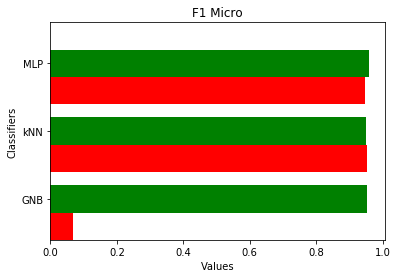

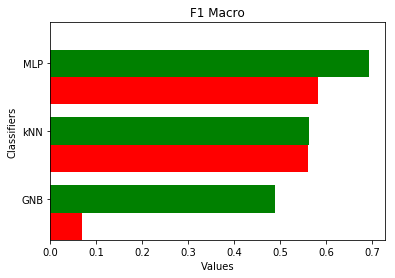

In [40]:
# Keeping values only for non-dummmy classifiers
baseline_fewer_f1_micro = {}
baseline_fewer_f1_macro = {}
for k in final_f1_macro.keys():
    baseline_fewer_f1_micro[k] = baseline_f1_micro[k]
    baseline_fewer_f1_macro[k] = baseline_f1_macro[k]

##Firstly for F1 Micro
names = list(final_f1_micro.keys())
prev_values = list(baseline_fewer_f1_micro.values())
values = list(final_f1_micro.values())
ind = np.arange(len(names))
width = 0.4
fig, ax = plt.subplots()
ax.barh(ind, prev_values, width, color='red', label='Baseline')
ax.barh(ind + width, values, width, color='green', label='Optimised')
plt.title('F1 Micro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
ax.set(yticks=ind + width, yticklabels=names, ylim=[2*width - 1, len(names)])
plt.show()

##Firstly for F1 Macro
names = list(final_f1_macro.keys())
prev_values = list(baseline_fewer_f1_macro.values())
values = list(final_f1_macro.values())
ind = np.arange(len(names))
width = 0.4
fig, ax = plt.subplots()
ax.barh(ind, prev_values, width, color='red', label='Baseline')
ax.barh(ind + width, values, width, color='green', label='Optimised')
plt.title('F1 Macro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
ax.set(yticks=ind + width, yticklabels=names, ylim=[2*width - 1, len(names)])
plt.show()

4. Δεν κοιτάμε για άλλες επιδόσεις (precision, recall, etc) διότι δεν είναι αντιπροσωπευτικές:

In [41]:
f1_micro_change = {}
f1_macro_change = {}
for key in final_f1_micro.keys():
    f1_micro_change[key] = final_f1_micro[key] - baseline_f1_micro[key]
    f1_macro_change[key] = final_f1_macro[key] - baseline_f1_macro[key]

print("Changes for classifiers for f1 micro :\n",f1_micro_change)
print("Changes for classifiers for f1 macro :\n",f1_macro_change)

Changes for classifiers for f1 micro :
 {'GNB': 0.8838120104438643, 'kNN': -0.004300414682844367, 'MLP': 0.011749347258485643}
Changes for classifiers for f1 macro :
 {'GNB': 0.4210535934988183, 'kNN': 0.0024360549674375953, 'MLP': 0.1104700250398758}


5. Σχολιασμός αποτελεσμάτων

Όσον αφορά τις τιμές precision και recall. Δεν είναι δόκιμο να τις χρησιμοποιήσουμε για να κρίνουμε την απόδοση των ταξινομητών διότι το dataset παρουσιάζει τεράστια ανισορροπία (20:1) και είναι αναμενόμενο αυτές οι μετρικές και στους 3 αλγορίθμους με τους οποίους ασχοληθήκαμε να είναι αρκετά υψηλές (>0.9) για τα δεδομένα μη πτωχευμένων επιχειρήσεων, τα οποία κυριρχούν στο dataset. Αξίζει να δώσουμε σημασία κυρίως στα f1-scores που δείχνουν πιο ξεκάθαρα το πόσο ένας ταξινομητής είναι biased ή όχι.
Επίσης, είναι σημαντικό να λάβουμε υπόψιν και το τι αντοπροσωπεύουν τα δείγματα του dataset. Πολλοί απο τους οικονομικούς δείκτες δεν είναι αντιπροσωπευτικοί της ύπαρξης ή μη χρεοκοπίας. Για παράδειγμα, μία επιχείρηση μπορεί να έχει ζημία, αλλά να μπορεί να επιβιώσει για παραπάνω χρόνια λόγω κεφαλαίων. Είναι εμφανές ότι οι δείκτες παρουσιάζουν μεγάλη αλληλοεξάρτηση η οποία επηρρεάζει αρκετά αρνητικά την εκπαίδευση, ενώ το περιορισμένο πλήθος δεδομένων για την σπανιότερη κλάση δεν μας δίνει μία ξεκάθαρη εικόνα. Για αυτό και απλά κάνοντας Oversampling δεν καταφέρνουμε ούτε στο ελάχιστο να φτάσουμε την δυνατότητα πρόβλεψης της συχνότερης κλάσης. Οπότε, στο υπάρχον dataset είναι πιθανό να μην υπάρχει μεγάλη ποικιλία για την σπανιότερη κλάση πάνω στην οποία μπορεί να βασιστεί ένα μοντέλο πρόβλεψης για αυτό το πρόβλημα. Τέλος, αν και τα μισά δείγματα είχαν έλλειψη κάποιου στοιχείου, συνολικά σε σχέση μετο dataframe ήταν αρκετά αραία, οπότε το imputing δεν επηρρεάσε σημαντικά την εκπαίδευση των ταξινομητών.  
Στην συνέχεια θα αναφερθούμε ξεχωριστά σε κάθε ταξινομητή με τον οποίο ασχοληθήκαμε:

Ο GNB στο baseline είχε τα χειρότερα αποτελέσματα από όλους, όμως μόνο με προεπεξεργασία του dataset έγινε ισάξιος με τους άλλους δύο βάσει f1 micro ενώ το f1 macro είναι χειρότερο από τους άλλους δύo, το οποίο είναι κατανοητό διότι πέτυχε την πρόβλεψη μόνο ενός  δείγματος από την σπανιότερη κλάση του test set.Επί της ουσίας, με την βελτιστοποίηση του dataset (sampler, scaler, PCA) ο GNB εκπαιδεύτηκε με τέτοιον τρόπο που δεν είναι δυνατόν να ξεχωρίσει καθόλου την πιο σπάνια κλάση, οπότε με το συγκεριμένο test που είναι αντιπροσωπευτικό του train test και του συνολικού dataset έχει μόνο καλά αποτελέσματα για την συχνότερη κλάση. Όμως, ακριβώς για αυτό δεν είναι αξιόπιστος για το πρόβλημα που έχουμε μπροστά μας, διότι ακόμα και το πιο αντιπροσωπευτικό παράδειγμα για τα δεδομένα της σπανιότερη κλάσης να του δώσουμε δεν θα μπορεί να το προβλέψει σωστά. 
Τέλος, ο χρόνος της εκπαίδευσης είναι σχετικά αναμενόμενος λόγω του μεγάλου dataset. Όσον αφορά τον χρόνο εκτέσης άπαξ και εκπαιδευτεί ο χρόνος πρόβλεψης είναι μηδαμινός διότι δεν χρειάζεται να κάνει πολλούς υπολογισμούς για να προβλέψει. 

Ο kNN έχει παρόμοια απόδοση πριν και μετά την βελτιστοποίηση. Αν και καταφέραμε να βελτιώσουμε ελάχιστα το f1 macro ,δηλαδή να μπορεί να προβλέπει λίγο καλύτερα την σπανιότερη περίπτωση αυτό ήταν ,σε μικρό βαθμό, εις βάρος της πρόβλεψης της συχνότερης κλάσης. Για αυτό και το f1 micro παρουσιάζει μία μικρή πτώση παρόμοιας τάξης μεγέθους με την άνοδο του f1 macro. Όπώς γνωρίζουμε ο kNN για να κάνει καλή δουλειά θέλει στον χώρο τα στοιχεία να είναι σχετικά διακριτά ανά κλάση και να μην είναι αρκετά αραιά, ειδικότερα αν υπάρχει μία κλάση με πολλά λιγότερα στοιχεία έναντι μιας άλλης. Είναι πιθανό, αν και ο λόγος samples ανά features εδώ φαίνεται να είναι ικανοποιητικός, το dataset να μην μπορεί να ικανοποιήσει τις συνθήκες που αναφέρθηκαν πριν και οι οποίες παίζουν τον σημαντικότερο λόγο για την απόδοση του kNN.
Τέλος, από άποψη χρόνου ενώ η εκπαίδευση είναι σχετικά γρήγορη (παρόμοια με GNB), η πρόβλεψη κρατούσε υπερβολικά πολύ σε σχέση με τους άλλους δύο ταξινομητές.

Τέλος, ο MLP παρουσιάζει την καλύτερη απόδοση βάσει των μετρικών που μας ενδιέφεραν. Έχει την επίδοση του kNN στο να πρόβλεπει δείγματα της συχνότερης κλάσης, και αρκετά καλύτερη δυνατότητα πρόβλεψης της σπανιότερης. Έχει το καλύτερο f1 macro score , άρα είδικα για την περίπτωση μας (πολύ ανισόρροπο dataset) το καλύτερο overall score. Μπορεί βέβαια να μην προβλέπει όπως ο GNB για την συχνότερη κλάση, αλλά είναι σημαντικά πιο αξιόπιστο.  
Όμως με την βελτιστοποίηση δεν είδαμε σημαντικά καλύτερα νούμερα (+0.1~ στο f1-macro), αλλά καταφέραμε να είναι πιο ικάνο να προβλέπει την σπανιότερη κλάση χωρίς να χάσουμε σε ακρίβεια όσον αφορά την συχνότερη. Επίσης, με την υψηλή τιμή max_iter( > 400) υπήρχε ο κίνδυνος να υπάρξει σημαντικό overfitting, αλλά τελικά δεν υπήρχε κάποιο θέμα στην τελική πρόβλεψη.  
Σχετικά με τον χρόνο, η εκπαίδευση του πήρε αναμενόμενα πολύ χρόνο λόγω των αριθμό των epochs (max_iter) και το πλήθος των features που έδωσε το PCA, όμως ο χρόνος πρόβλεψης είναι πολύ καλός.

Συμπερασματικά, για το συγκεκριμένο πρόβλημα την καλύτερη απόδοση είχε ο MLP. Όμως, πέρα απο αυτό φαίνεται ότι έχει και το μεγαλύτερο περιθώριο βελτίωσης αν του δωθεί ένα πιο προσεγμένο από άποψη χαρακτηριστικών και ισορροπίας dataset σχετικά με το πρόβλημα μας. Αν και ο kNN είχε λίγο χείροτερη επίδοση, δεν μπορέσαμε στις δοκιμές μας και με το GridSearchCV να μας δημιουργήσει την πεποίθηση ότι είναι κατάλληλος για αυτό το πρόβλημα με αυτά τα χαρακτηριστικά (δεν καταφέραμε κάποια βελτίωση όυτε με PCA , ούτε με OverSampling).